In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import os
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_matching_tools.io.graph_dataset import GraphDataset
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sio
import tools.graph_processing as gp
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import f1_score

In [3]:
import scipy.io as sco
from scipy.special import softmax
import pickle
from scipy.stats import betabinom
import seaborn as sns
import tools.graph_processing as gp
import tools.graph_visu as gv
from matplotlib.pyplot import figure
import random
from torch_geometric.utils.convert import from_networkx
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch.nn.functional import one_hot
from sklearn.preprocessing import OneHotEncoder
from torch.nn import Linear,BatchNorm1d,Sequential,ReLU
import torch.nn.functional as F
from math import ceil
import torch_geometric as pyg
from torch_geometric.nn import GCNConv,GINConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn import TopKPooling
from torch_geometric.data import Data
from torch_geometric.loader import DenseDataLoader
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv, DenseGraphConv, dense_mincut_pool,GINConv
%matplotlib inline

In [4]:
sns.set(rc={'figure.figsize':(15,9)})

In [5]:
path_to_phenotype = '../data/ABIDE/Phenotypic_V1_0b_traitements_visual_check_GA.xls'
Abide_phen = pd.read_excel(path_to_phenotype, engine="xlrd")

In [6]:
# Removing subjects witch QC = 3 or 4

Abide_phen = Abide_phen.drop(Abide_phen[Abide_phen['FS segmentation (0=OK 1=bon 2=moyen 3=pas bon 4=echec)'] == 3].index)
Abide_phen = Abide_phen.drop(Abide_phen[Abide_phen['FS segmentation (0=OK 1=bon 2=moyen 3=pas bon 4=echec)'] == 4].index)


# Removing sites with no graphs present

Abide_phen = Abide_phen.drop(Abide_phen[Abide_phen['SITE_ID'] == 'OLIN'].index)
Abide_phen = Abide_phen.drop(Abide_phen[Abide_phen['SITE_ID'] == 'SBL'].index)
Abide_phen = Abide_phen.drop(Abide_phen[Abide_phen['SITE_ID'] == 'MAX_MUN'].index)


In [7]:
# remove sites with less than 20 subjects
Abide_phen = Abide_phen.groupby('SITE_ID').filter(lambda x : len(x)>20)

<AxesSubplot:>

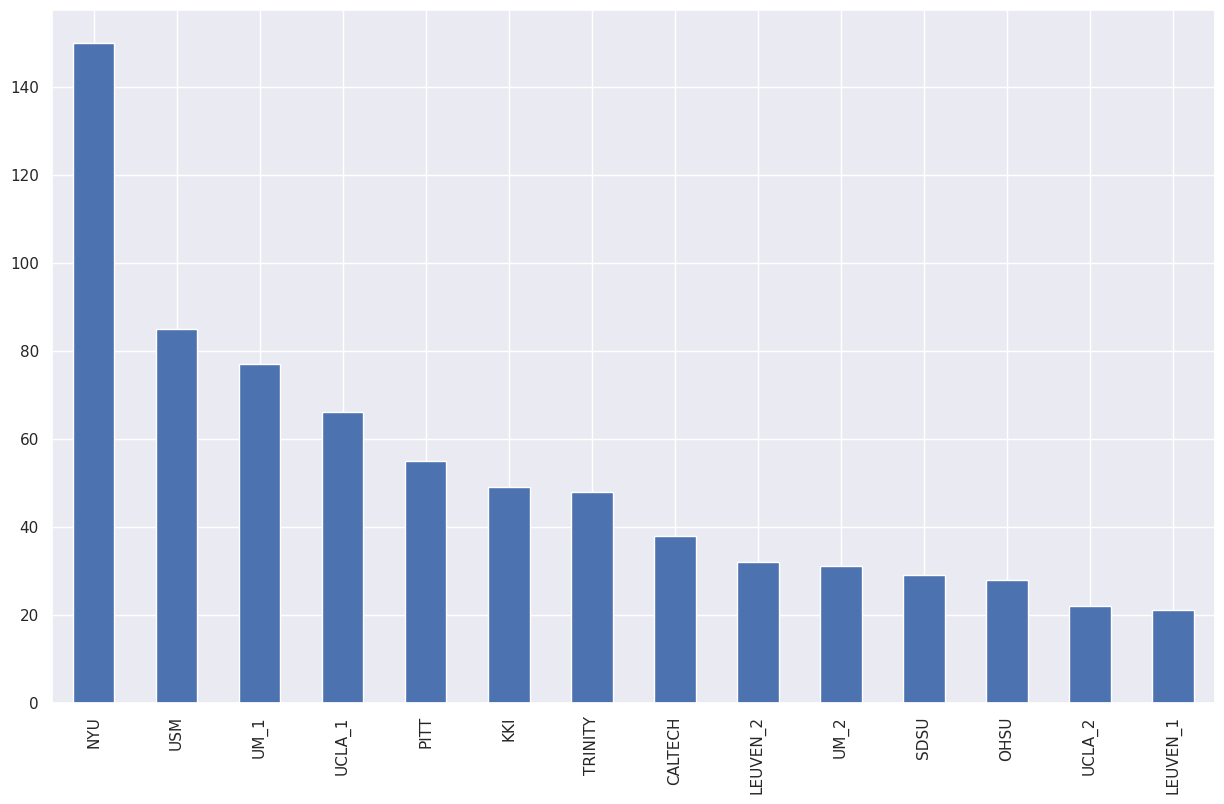

In [8]:
Abide_phen['SITE_ID'].value_counts().plot(kind='bar')

In [9]:
path_ABIDE = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/ABIDE/graph_lh/'
path_save  = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/ABIDE/graph_renamed_lh/'

In [10]:
# Save renamed graphs and make correspondence (Original Version: going through original graphs to find the correspondence in th dataframe)

subjects = np.sort(os.listdir(path_ABIDE)) # all original graphs

sub_ID = list(Abide_phen['SUB_ID'])

corresp_list = []
corresp = []

unknown_subj = []

for count,subject in enumerate(subjects):
    
    subj = int(subject.split('_')[0][2:])
    
    if subj in sub_ID: 
        
        graph = nx.read_gpickle(path_ABIDE + subject)
        
        #nx.write_gpickle(graph, os.path.join(path_save,"graph_{:05d}".format(count) + ".gpickle"))
        
        graph_name = "graph_{:05d}".format(count)
        
        age = Abide_phen[Abide_phen['SUB_ID'] == subj]['AGE_AT_SCAN'].to_numpy()[0]
        sex = Abide_phen[Abide_phen['SUB_ID'] == subj]['SEX'].to_numpy()[0]
        dxg = Abide_phen[Abide_phen['SUB_ID'] == subj]['DX_GROUP'].to_numpy()[0]
        
        corresp_list.append([subj,age,sex,dxg])
        corresp.append([subj,graph_name])
        
    else:
        # Some graphs with no correspondence in the df, except Stanford and Yale
        unknown_subj.append(subj)
        
    
corresp_list = np.array(corresp_list)   
corresp_ABIDE = pd.DataFrame({'subj': corresp_list[:,0], 'age': corresp_list[:,1], 'sex': corresp_list[:,2], 'dxg':corresp_list[:,3]})

In [11]:
#pickle.dump(corresp, open( "Abide_correspondence.pickle", "wb" ))
#corresp = pickle.load(open( "Abide_correspondence.pickle", "rb" ))

In [12]:
np.unique(Abide_phen['SITE_ID'].values)

array(['CALTECH', 'KKI', 'LEUVEN_1', 'LEUVEN_2', 'NYU', 'OHSU', 'PITT',
       'SDSU', 'TRINITY', 'UCLA_1', 'UCLA_2', 'UM_1', 'UM_2', 'USM'],
      dtype=object)

In [13]:
# # NYU / UM_1 / USM

# df_NYU = Abide_phen[Abide_phen['SITE_ID']=='NYU']
# df_UM_1 = Abide_phen[Abide_phen['SITE_ID']=='UM_1']
# df_USM = Abide_phen[Abide_phen['SITE_ID']=='USM']
# df_UCLA_1 = Abide_phen[Abide_phen['SITE_ID']=='UCLA_1']
# df_KKI = Abide_phen[Abide_phen['SITE_ID']=='KKI']
# df_TRINITY = Abide_phen[Abide_phen['SITE_ID']=='TRINITY']

# frames = [df_NYU, df_UM_1, df_USM, df_UCLA_1, df_KKI, df_TRINITY]

# df_merged = pd.concat(frames)
# sub_ID_merged = list(df_merged['SUB_ID'])

In [14]:
sub_ID_merged = list(Abide_phen['SUB_ID'])

In [15]:
sel_graphs = []
list_graphs = []

sorted_df = []

for sub,graph in corresp:
    if sub in sub_ID_merged:
        sel_graphs.append(graph)
        
        list_graphs.append(nx.read_gpickle(path_save + graph + '.gpickle'))
        
        site = Abide_phen[Abide_phen['SUB_ID'] == sub]['SITE_ID'].to_string().split()[1]
        age = Abide_phen[Abide_phen['SUB_ID'] == sub]['AGE_AT_SCAN'].to_numpy()[0]
        sex = Abide_phen[Abide_phen['SUB_ID'] == sub]['SEX'].to_numpy()[0]
        dxg = Abide_phen[Abide_phen['SUB_ID'] == sub]['DX_GROUP'].to_numpy()[0]
        
        sorted_df.append([site,sub,age,sex,dxg])

sorted_df = np.array(sorted_df)
sorted_df = pd.DataFrame({'site': sorted_df[:,0] ,'subj': sorted_df[:,1], 'age': sorted_df[:,2], 'sex': sorted_df[:,3], 'dxg':sorted_df[:,4]})

In [16]:
# sorted_df['site'].value_counts().plot(kind='bar')

In [17]:
def train_test_divide(df,ratio = 0.5):
    
    df_1 = df[df['dxg']=='1']
    df_2 = df[df['dxg']=='2']
    
    lab_1 = df_1.sample(frac = ratio)
    lab_2 = df_2.sample(frac = ratio)
    
    train_df = pd.concat([lab_1,lab_2],axis=0)
    
    rest_lab_1 = df_1.drop(lab_1.index)
    rest_lab_2 = df_2.drop(lab_2.index)
    
    test_df = pd.concat([rest_lab_1,rest_lab_2],axis=0)
    
    return train_df, test_df

In [18]:
def labels_by_cite(df,column_name = None):
    
    if column_name is not None:
        
        count_patho = len(df[df[column_name] == 0])
        count_control = len(df[df[column_name] == 1])
    else:
        
        count_patho = len(df[df['dxg'] == '1'])
        count_control = len(df[df['dxg'] == '2'])
    
    return count_patho, count_control

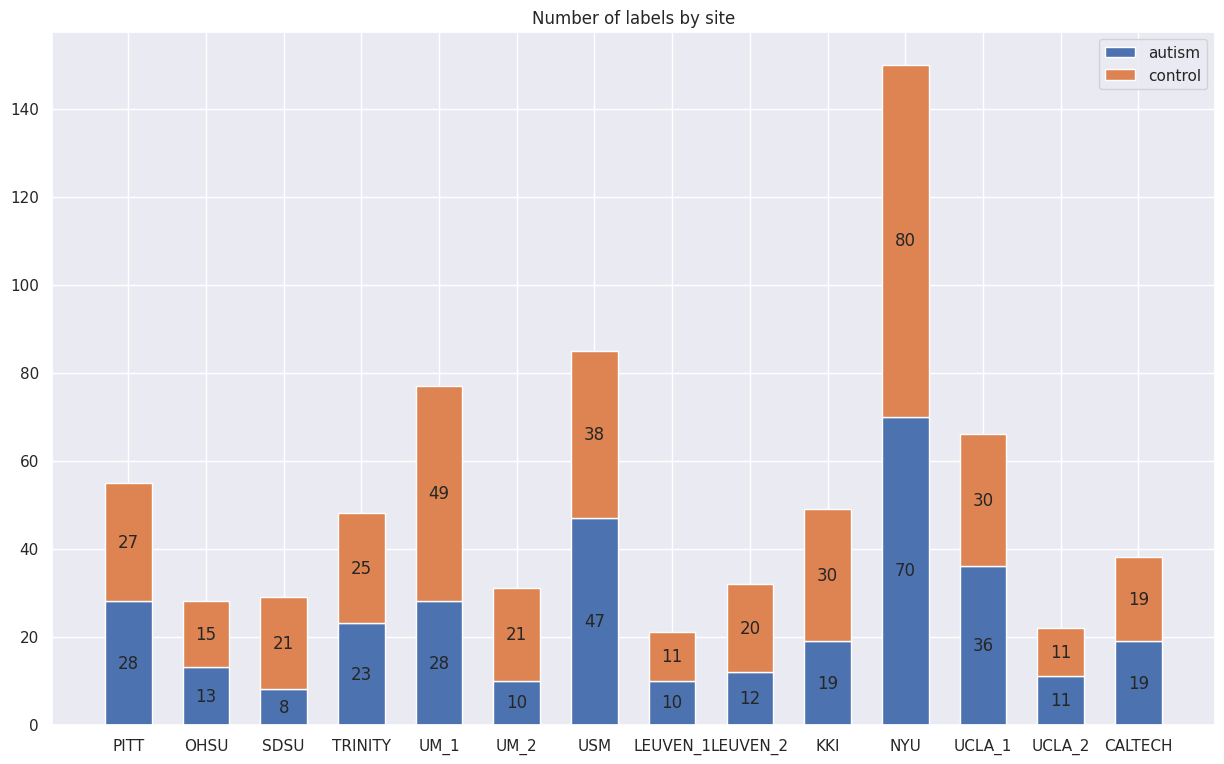

In [19]:
#species = ('Adelie', 'Chinstrap', 'Gentoo')
site = tuple(sorted_df.site.unique())

list_count_A = []
list_count_C = []

train_df = sorted_df[sorted_df['site']==''] # init df with columns
test_df = sorted_df[sorted_df['site']==''] # init df with columns


for s in site:
    df = sorted_df[sorted_df['site']== s]
    
    count_patho, count_control = labels_by_cite(df)
    
    list_count_A.append(count_patho) #patho counts
    list_count_C.append(count_control) #controls counts
    
    df_tr, df_tst = train_test_divide(df,ratio = 0.6)
    
    train_df = pd.concat([train_df,df_tr],axis=0)
    test_df = pd.concat([test_df,df_tst],axis =0)
    

dxg_counts = {
    'autism': np.array(list_count_A),
    'control': np.array(list_count_C),
}

width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(len(site))

for dxg, dxg_count in dxg_counts.items():
    p = ax.bar(site, dxg_count, width, label=dxg, bottom=bottom)
    bottom += dxg_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of labels by site')
ax.legend()

plt.show()



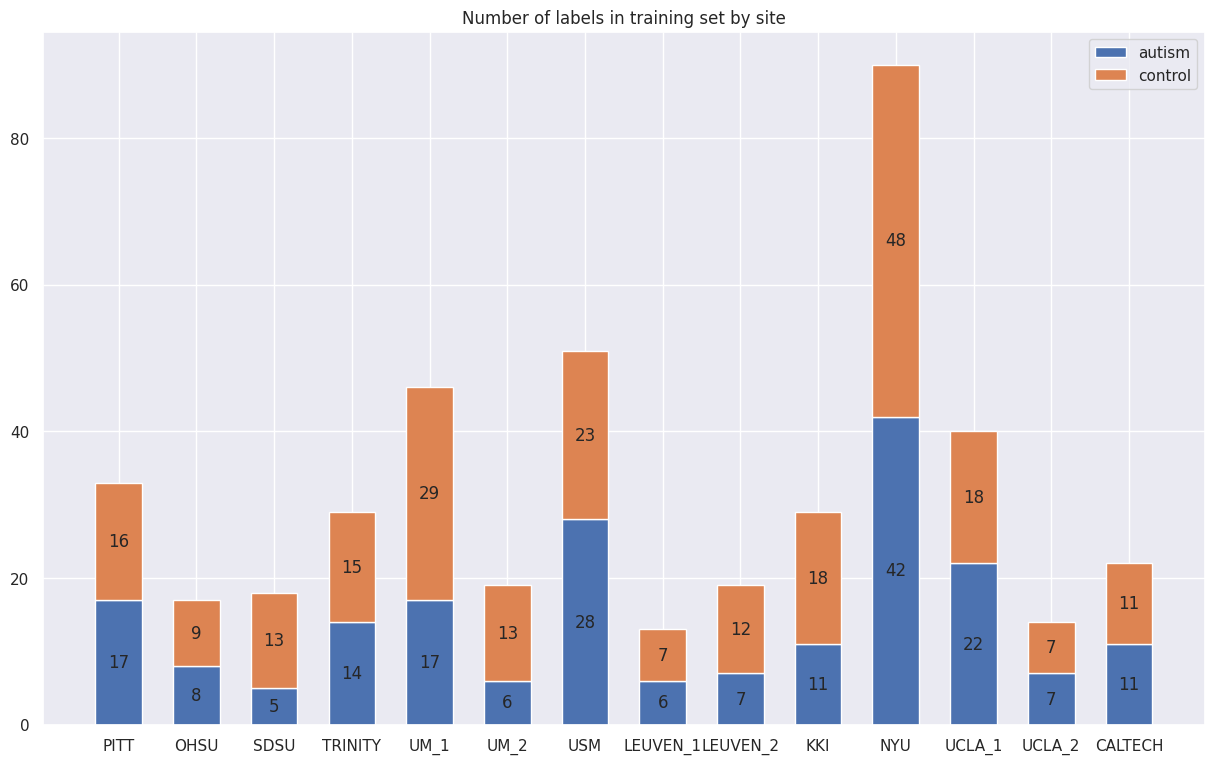

In [20]:
site = tuple(train_df.site.unique())

list_count_A = []
list_count_C = []

for s in site:
    df = train_df[train_df['site']== s]
    
    count_patho, count_control = labels_by_cite(df)
    
    list_count_A.append(count_patho) #patho counts
    list_count_C.append(count_control) #controls counts
    

dxg_counts = {
    'autism': np.array(list_count_A),
    'control': np.array(list_count_C),
}

width = 0.6  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(len(site))

for dxg, dxg_count in dxg_counts.items():
    p = ax.bar(site, dxg_count, width, label=dxg, bottom=bottom)
    bottom += dxg_count

    ax.bar_label(p, label_type='center')

ax.set_title('Number of labels in training set by site')
ax.legend()

plt.show()

In [21]:
def load_graphs_by_corresp(df, corresp):
    
    list_graphs = []
    
    for sub in np.array(df['subj'], dtype=np.int32):
        
        for cor in corresp:
            
            if sub == cor[0]:
                
                list_graphs.append(nx.read_gpickle(path_save + cor[1] +'.gpickle')) # load graph of corresp subject
            
    return list_graphs

In [22]:
list_graphs_train = load_graphs_by_corresp(train_df,corresp) # graphs corresponding to train dataframe
list_graphs_test = load_graphs_by_corresp(test_df,corresp)   # graphs corresponding to test dataframe

In [23]:
lb = preprocessing.LabelBinarizer()

train_labels = lb.fit_transform(list(train_df['dxg']))
test_labels = lb.fit_transform(list(test_df['dxg']))

In [24]:
def graph_remove_dummy_nodes(graph):
    nodes_dummy_true = [x for x,y in graph.nodes(data=True) if y['is_dummy']==True]
    graph.remove_nodes_from(nodes_dummy_true)
    #print(len(graph.nodes))

In [25]:
def convert_to_pytg_graphs(list_graphs, list_labels):
    
    dataset = []

    for i,g in enumerate(list_graphs):

        #graph_remove_dummy_nodes(g) # remove dummy nodes
        g.remove_edges_from(nx.selfloop_edges(g)) # remove self loop edges

        attr_coords = np.array(list(nx.get_node_attributes(g,'sphere_3dcoords').values()))
        attr_basin_area = np.array(list(nx.get_node_attributes(g,'basin_area').values())).reshape([len(g),1])
        attr_basin_thickness = np.array(list(nx.get_node_attributes(g,'basin_thickness').values())).reshape([len(g),1])
        attr_depth = np.array(list(nx.get_node_attributes(g,'depth').values())).reshape([len(g),1])

        attr_concat = np.concatenate((attr_coords,attr_basin_area,attr_basin_thickness,attr_depth),axis = 1)

        x = torch.tensor(attr_concat,dtype=torch.float)

        #x = torch.tensor(nx.adjacency_matrix(g).todense(),dtype=torch.float)
        y = torch.tensor(list_labels[i],dtype=torch.long)
        edge_index = torch.tensor(list(g.edges))

        dataset.append(Data(x=x, y=y, edge_index=edge_index.t().contiguous())) #
        
    return dataset
    

In [26]:
abide_train = convert_to_pytg_graphs(list_graphs_train, train_labels)
abide_test = convert_to_pytg_graphs(list_graphs_test, test_labels)

In [27]:
train_loader = DataLoader(abide_train, batch_size=32, shuffle=True)
test_loader = DataLoader(abide_test, batch_size=32, shuffle=True)

In [28]:
num_node_features = abide_train[0].num_features
num_node_features

6

In [42]:
# Create MLP Model

class MLP(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=16):        
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        
        
        self.lin1 = Linear(in_channels, 8)
        self.lin2 = Linear(8, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        
        emb = self.lin1(x)
        x = emb.relu()
        emb = self.lin2(x)
        x = emb.relu()
        g_emb = global_mean_pool(x, batch)
        out = self.lin3(g_emb)
        
        return out, g_emb, emb, x

    
model = MLP(num_node_features, 2)
print(model)

MLP(
  (lin1): Linear(in_features=6, out_features=8, bias=True)
  (lin2): Linear(in_features=8, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=2, bias=True)
)


In [30]:
# # Create GAT Model

# class GAT(torch.nn.Module):
#     def __init__(self, hidden_channels):        
#         super(GAT, self).__init__()
#         torch.manual_seed(12345)
#         self.in_head = 2
#         self.out_head = 1
        
#         self.emb_dim = 8
        
        
#         self.conv1 = GATConv(num_node_features, hidden_channels, heads=self.in_head)
#         self.conv2 = GATConv(hidden_channels*self.in_head, hidden_channels,concat=False)
#         #self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
#         self.lin = Linear(self.emb_dim, 2)
        

#     def forward(self, x, edge_index, batch):
#         # 1. Obtain node embeddings 
#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         #x = self.conv2(x, edge_index)
#         #x = x.relu()
#         emb,attn_weights = self.conv2(x, edge_index,return_attention_weights=True)

#         # 2. Readout layer
#         g_emb = global_mean_pool(emb, batch)  # [batch_size, hidden_channels] TopKPooling
#         #g_emb = TopKPooling(emb, batch)

#         # 3. Apply a final classifier
#         out = F.dropout(g_emb, p=0.5, training=self.training)
#         out = self.lin(out)
        
#         return out, g_emb, emb, attn_weights

# model = GAT(hidden_channels=8)
# print(model)

In [31]:
class mincutnet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=8):
        super(mincutnet, self).__init__()
        
        self.in_head = 2
        self.out_head = 1
        
        self.emb_dim = 16 # embedding dimension
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=self.in_head,dropout=0.2)

#        self.conv3 = GATConv(hidden_channels, self.emb_dim, concat=False, dropout=0.6)
        
        num_of_centers =  18
        self.pool1 = Linear(self.emb_dim, num_of_centers) # The degree of the node belonging to any of the centers
        
        self.conv3 = DenseGraphConv(self.emb_dim, self.emb_dim)

        #self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin2 = Linear(self.emb_dim, out_channels)

    def forward(self, x, edge_index, batch): 
        
        x = F.relu(self.conv1(x, edge_index))
        #x = F.relu(self.conv2(x, edge_index))
        node_emb, attn_weights = self.conv2(x, edge_index,return_attention_weights=True)
        #x = node_emb.relu()

        x, mask = to_dense_batch(node_emb, batch) 
        
        adj = to_dense_adj(edge_index, batch) 
        s = self.pool1(x)

        
        x, adj, mincut_loss, ortho_loss = dense_mincut_pool(x, adj, s, mask) 
        x = self.conv3(x, adj) 
        g_emb = x.mean(dim=1)
        #x = F.relu(self.lin1(x)) 
        out = self.lin2(g_emb)
        return out, g_emb, node_emb, s

model = mincutnet(num_node_features, 2)
print(model)

mincutnet(
  (conv1): GCNConv(6, 8)
  (conv2): GATConv(8, 8, heads=2)
  (pool1): Linear(in_features=16, out_features=18, bias=True)
  (conv3): DenseGraphConv(16, 16)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [32]:
# class GIN(torch.nn.Module):
#     """GIN"""
#     def __init__(self, in_channels, out_channels, hidden_channels=8):
#         super(GIN, self).__init__()
#         self.conv1 = GINConv(
#             Sequential(Linear(in_channels, hidden_channels),
#                        BatchNorm1d(hidden_channels), ReLU(),
#                        Linear(hidden_channels, hidden_channels), ReLU()))
#         self.conv2 = GINConv(
#             Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
#                        Linear(hidden_channels, hidden_channels), ReLU()))
#         self.conv3 = GINConv(
#             Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
#                        Linear(hidden_channels, hidden_channels), ReLU()))
#         self.lin1 = Linear(hidden_channels*3, hidden_channels*3)
#         self.lin2 = Linear(hidden_channels*3, out_channels)

#     def forward(self, x, edge_index, batch):
#         # Node embeddings 
#         h1 = self.conv1(x, edge_index)
#         h2 = self.conv2(h1, edge_index)
#         h3 = self.conv3(h2, edge_index)

#         # Graph-level readout
#         h1 = global_add_pool(h1, batch)
#         h2 = global_add_pool(h2, batch)
#         h3 = global_add_pool(h3, batch)

#         # Concatenate graph embeddings
#         g_emb = torch.cat((h1, h2, h3), dim=1)

#         # Classifier
#         h = self.lin1(g_emb)
#         h = h.relu()
#         h = F.dropout(h, p=0.5, training=self.training)
#         out = self.lin2(h)
        
#         return out, g_emb, h3,h2

# model = GIN(num_node_features, 2)
# print(model)

In [33]:
# sizes = [nx.number_of_nodes(i) for i in list_graphs_train]
# average_nodes =  np.mean(sizes)

# class mincutnet_2(torch.nn.Module):
#     def __init__(self, in_channels, out_channels, hidden_channels=16):
#         super().__init__()

#         self.conv1 = GCNConv(in_channels, hidden_channels)
#         num_nodes = ceil(0.5 * average_nodes)
#         self.pool1 = Linear(hidden_channels, num_nodes)

#         self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
#         num_nodes = ceil(0.5 * num_nodes)
#         self.pool2 = Linear(hidden_channels, num_nodes)

#         self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)

#         self.lin1 = Linear(hidden_channels, hidden_channels)
#         self.lin2 = Linear(hidden_channels, out_channels)

#     def forward(self, x, edge_index, batch):
#         node_emb = self.conv1(x, edge_index).relu()

#         x, mask = to_dense_batch(node_emb, batch)
#         adj = to_dense_adj(edge_index, batch)

#         s = self.pool1(x)
#         x, adj, mc1, o1 = dense_mincut_pool(x, adj, s, mask)

#         x = self.conv2(x, adj).relu()
#         s = self.pool2(x)

#         x, adj, mc2, o2 = dense_mincut_pool(x, adj, s)

#         x = self.conv3(x, adj)

#         g_emb = x.mean(dim=1)
#         x = self.lin1(g_emb).relu()
#         out = self.lin2(x)
        
#         return out, g_emb, node_emb, s
    
# model = mincutnet_2(num_node_features, 2)
# print(model)

In [34]:
#model = GCN(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:# Iterate in batches over the training dataset.
        out, g_emb, node_emb, s = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    
    predictions = []
    
    for data in loader:
        out, g_emb, node_emb, s =  model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        predictions.append(pred)
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
    test_acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
            
    return test_acc,model, predictions   

In [35]:
train_acc_lst = []
test_acc_lst = []

best_accu = 0.0

for epoch in range(1, 99):
    train()
    train_acc,_ ,_= test(train_loader)
    train_acc_lst.append(train_acc)
    
    test_acc, model,_ = test(test_loader)
    
    if test_acc > best_accu:
        
        print('Saving Model ... ')
        torch.save(model.state_dict(), 'abide_mincutpool.model')
        best_accu = test_acc
        
    test_acc_lst.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Saving Model ... 
Epoch: 001, Train Acc: 0.5432, Test Acc: 0.5395
Epoch: 002, Train Acc: 0.4841, Test Acc: 0.4983
Epoch: 003, Train Acc: 0.4591, Test Acc: 0.4742
Epoch: 004, Train Acc: 0.5364, Test Acc: 0.5395
Epoch: 005, Train Acc: 0.5341, Test Acc: 0.5223
Epoch: 006, Train Acc: 0.5068, Test Acc: 0.5395
Epoch: 007, Train Acc: 0.4886, Test Acc: 0.4433
Epoch: 008, Train Acc: 0.5295, Test Acc: 0.4983
Epoch: 009, Train Acc: 0.5159, Test Acc: 0.4536
Epoch: 010, Train Acc: 0.5455, Test Acc: 0.5292
Saving Model ... 
Epoch: 011, Train Acc: 0.5432, Test Acc: 0.5430
Epoch: 012, Train Acc: 0.5227, Test Acc: 0.5361
Epoch: 013, Train Acc: 0.5614, Test Acc: 0.5326
Saving Model ... 
Epoch: 014, Train Acc: 0.5523, Test Acc: 0.5567
Epoch: 015, Train Acc: 0.5477, Test Acc: 0.5430
Saving Model ... 
Epoch: 016, Train Acc: 0.5636, Test Acc: 0.5601
Epoch: 017, Train Acc: 0.5614, Test Acc: 0.5223
Saving Model ... 
Epoch: 018, Train Acc: 0.5636, Test Acc: 0.5636
Epoch: 019, Train Acc: 0.5432, Test Acc: 0.543

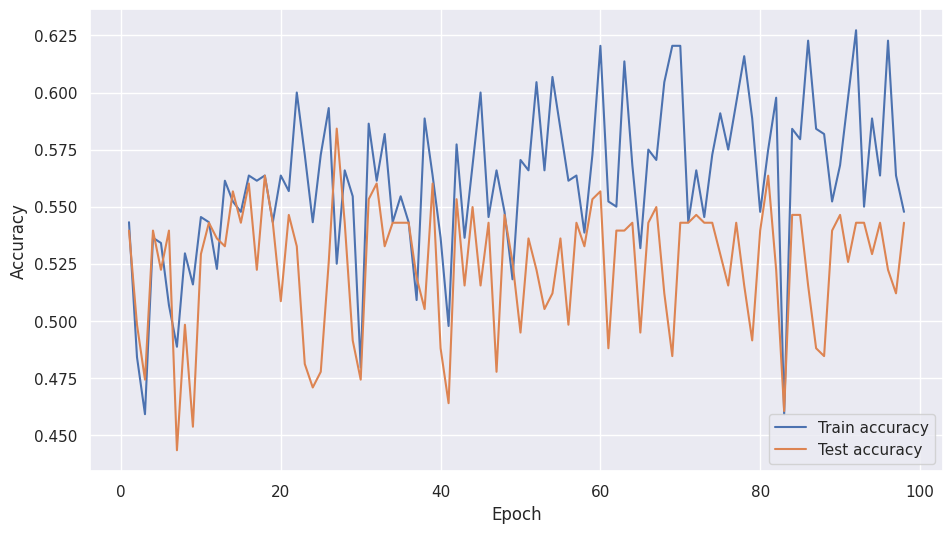

In [36]:
sns.set(rc={'figure.figsize':(11,6)})
epochs = np.arange(1,99,1)
plt.plot(epochs, train_acc_lst,label='Train accuracy')
plt.plot(epochs, test_acc_lst,label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")

In [37]:
# model.load_state_dict(torch.load('abide_mincutpool.model'))

<All keys matched successfully>

In [38]:
test_batch = DataLoader(abide_test, batch_size=len(abide_test), shuffle=False)

test_acc,_,pred = test(test_batch)
pred = pred[0].detach().numpy()

print('Test accuracy: ', test_acc * 100)

Test accuracy:  58.4192439862543


In [39]:
def labels_by_cite(df,column_name = None):
    
    if column_name is not None:
        
        count_patho = len(df[df[column_name] == 0])
        count_control = len(df[df[column_name] == 1])
    else:
        
        count_patho = len(df[df['dxg'] == 0])
        count_control = len(df[df['dxg'] == 1])
    
    return count_patho, count_control

In [40]:
test_df_updated = test_df.copy()

dxg_relabelled = [0 if i == '1' else 1 for i in list(test_df_updated['dxg'])]

test_df_updated['pred'] = pred
test_df_updated['dxg'] = dxg_relabelled

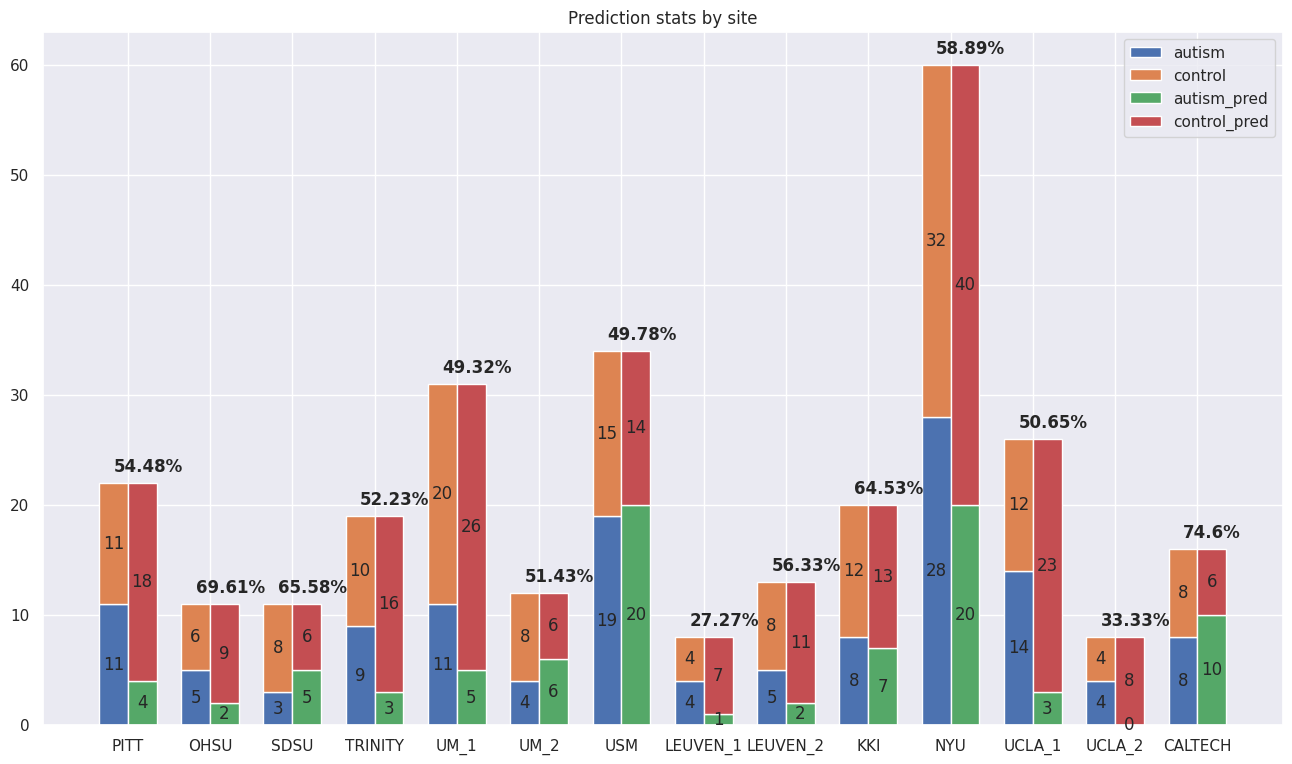

In [41]:
sns.set(rc={'figure.figsize':(16,9)})

#species = ('Adelie', 'Chinstrap', 'Gentoo')
site = tuple(test_df_updated.site.unique())

list_count_A = []
list_count_C = []

list_count_A_pred = []
list_count_C_pred = []

accu_by_site = []


for s in site:
    df = test_df_updated[test_df_updated['site']== s]
    
    count_patho, count_control = labels_by_cite(df,None)
    
    count_patho_pred, count_control_pred = labels_by_cite(df,column_name="pred")
    
    
    list_count_A.append(count_patho) #patho counts gt
    list_count_C.append(count_control) #controls counts gt
    
    list_count_A_pred.append(count_patho_pred) #patho counts pred
    list_count_C_pred.append(count_control_pred) #controls counts pred
    
    accu_by_site.append(f1_score(df['dxg'],df['pred'],average = 'weighted'))
    

gt_counts = {
    'autism': np.array(list_count_A),
    'control': np.array(list_count_C),
}

pred_counts = {
    'autism_pred': np.array(list_count_A_pred),
    'control_pred': np.array(list_count_C_pred),
}


width = 0.35  # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
bottom = np.zeros(len(site))
ind = np.arange(len(site))

for dxg, dxg_count in gt_counts.items():
    p = ax.bar(ind, dxg_count, width, label=dxg, bottom=bottom)
    bottom += dxg_count

    ax.bar_label(p, label_type='center')

bottom = np.zeros(len(site))

for dxg, dxg_count in pred_counts.items():
    p1 = ax.bar(ind+width, dxg_count, width, label=dxg, bottom=bottom)
    bottom += dxg_count

    ax.bar_label(p1, label_type='center')
    

for i in range(len(site)):
    plt.text(i, list_count_A[i] + list_count_C[i] + 1, str(round(accu_by_site[i] *100 , 2)) + '%', weight = 'bold', )
    

plt.xticks(ind + width / 2, site)

ax.set_title('Prediction stats by site')
ax.legend()

plt.show()